In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

2017-08-23


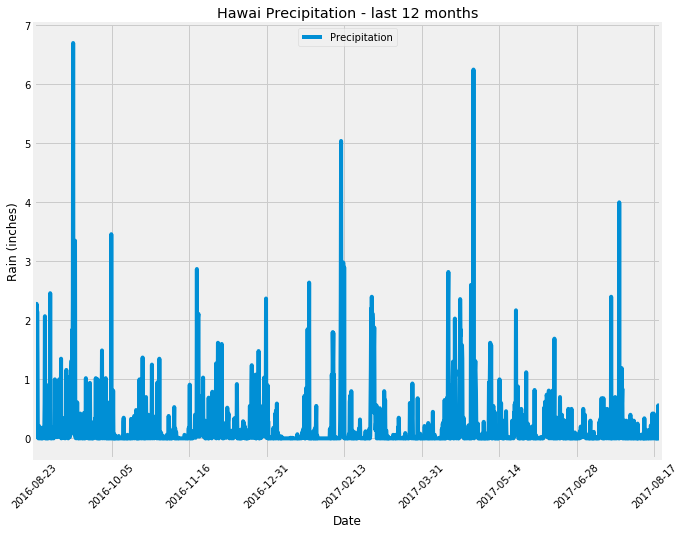

In [11]:

#Shiw the data from the database
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()
results = session.query(Measurement.station, Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).all()
results
# Get the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
print(last_date)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
# Retrieve precipitation data for the year
precipt_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipt_df = pd.DataFrame(precipt_query, columns=['date','precipitation'])
#precipt_df['date'] = pd.to_datetime(precipt_df['date'], format='%Y-%m-%d')
precipt_df.set_index('date', inplace=True)

#remove null values
precipt_df=precipt_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
precipt_df.plot(figsize=(10,8), rot=45)
plt.xlabel("Date")
plt.ylabel("Rain (inches)")
plt.title("Hawai Precipitation - last 12 months")
plt.legend(["Precipitation"], loc="upper center")
plt.savefig("Images/Precep_year.png")
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipt_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station).distinct().count()
print(f"Number of Stations in the dataset: {num_stations}")

Number of Stations in the dataset: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for station, count in active_stations:
    print(f"Station", station, "with", count, "observations")

Station USC00519281 with 2772 observations
Station USC00519397 with 2724 observations
Station USC00513117 with 2709 observations
Station USC00519523 with 2669 observations
Station USC00516128 with 2612 observations
Station USC00514830 with 2202 observations
Station USC00511918 with 1979 observations
Station USC00517948 with 1372 observations
Station USC00518838 with 511 observations


In [15]:
# Find the station with the most observations
print(f"The most active station was",active_stations[0][0])

The most active station was USC00519281


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
busiest_station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()
print(f"Temperatures for the most active station {active_stations[0][0]}")
print(f"Low: {busiest_station_temps[0][0]} High:{busiest_station_temps[0][1]} Average: {round(busiest_station_temps[0][2], 1)}")

Temperatures for the most active station USC00519281
Low: 54.0 High:85.0 Average: 71.7


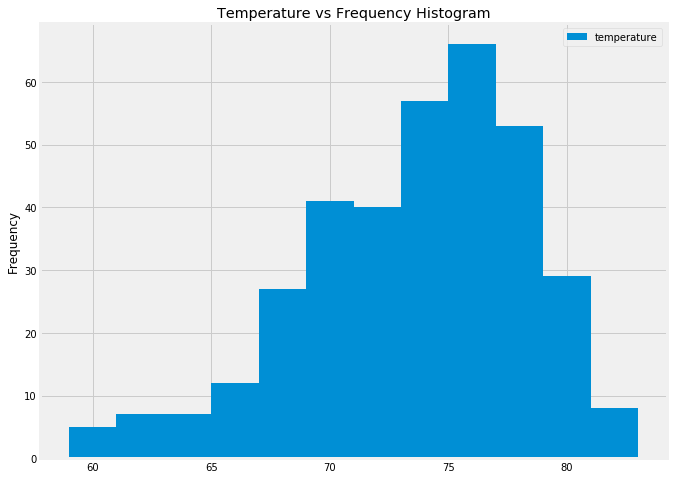

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_most_observ = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_most_observ=station_most_observ[0]
observ = session.query(Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == station_most_observ).all()
observ = pd.DataFrame(observ, columns=['temperature'])
observ[['temperature']].plot(kind='hist', bins=12, figsize=(10,8))
plt.ylabel('Frequency')
plt.title('Temperature vs Frequency Histogram')
plt.savefig("Images/most_observations.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = (calc_temps('2017-08-12', '2017-08-22'))
print(f"Low Temp: {trip_dates[0][0]} F")
print(f"Avg Temp: {round(trip_dates[0][1], 2)} F")
print(f"High Temp: {trip_dates[0][2]} F")

Low Temp: 70.0 F
Avg Temp: 78.59 F
High Temp: 85.0 F


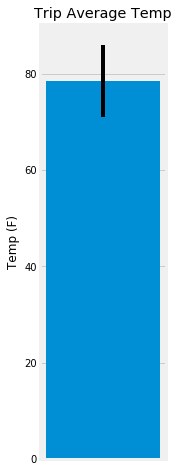

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_dates[0][2] - trip_dates[0][0]
avg_temp = trip_dates[0][1]
fig, ax = plt.subplots(figsize=(2, 8))
ax.bar(1, avg_temp, yerr = peak_to_peak/2, width = 0.1)
ax.set_title('Trip Average Temp')
ax.set_xticks([0])
ax.set_ylabel('Temp (F)')
plt.savefig('Images/TripAvgTemp.png')
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_year_start = dt.date(2017, 8, 12)
prev_year_end = dt.date(2017, 8, 22)
rainfall_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude,\
                             Station.elevation, func.avg(Measurement.prcp)).\
                             filter(Measurement.station==Station.station).\
                             filter(func.strftime("%Y-%m-%d", Measurement.date)>= prev_year_start).\
                             group_by(Station.station).order_by(func.avg(Measurement.prcp).desc()).all()
rainfall_data_df = pd.DataFrame(rainfall_data, columns=['Station', 'Name','Latitude', 'Longitude', 'Elevation', 'Precipitation'])
rainfall_data_df


,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.325556
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.085000
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.042500
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.004444
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.002000


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
trip_date_range = session.query(Measurement.date).filter(Measurement.date>= prev_year_start).filter(Measurement.date<=prev_year_end).\
    group_by(Measurement.date).all()

# Stip off the year and save a list of %m-%d strings
trip_date_tp = [x[0] for x in trip_date_range]
trip_date_no_year = [x[5:] for x in trip_date_tp]
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_for_trip = [session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                                       filter(func.strftime("%m-%d", Measurement.date) >= trip_date_no_year[0]).\
                                       filter(func.strftime("%m-%d", Measurement.date) <= trip_date_no_year[-1]).\
                                       group_by(func.strftime("m-%d", Measurement.date)).all()]
daily_normals_for_trip

[[(67.0, 76.52727272727273, 83.0),
  (71.0, 76.98245614035088, 84.0),
  (71.0, 76.77777777777777, 82.0),
  (69.0, 76.47169811320755, 83.0),
  (69.0, 76.08, 83.0),
  (69.0, 76.125, 83.0),
  (70.0, 76.92307692307692, 84.0),
  (69.0, 75.94642857142857, 85.0),
  (68.0, 76.45283018867924, 82.0),
  (67.0, 76.4, 83.0),
  (69.0, 76.47169811320755, 84.0)]]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms = []
for trip_date in trip_date_no_year:
    day ={}
    day['Date']=f"2018-{trip_date}"
    daily_norm=daily_normals(trip_date)
    day['tmin']=daily_norm[0][0]
    day['tavg']=daily_norm[0][1]
    day['tmax']=daily_norm[0][2]
    daily_norms.append(day)
daily_norms_df = pd.DataFrame(daily_norms)
daily_norms_df.set_index('Date', inplace=True)
daily_norms_df

,tavg,tmax,tmin
Date,,,
2018-08-12,76.527273,83.0,67.0
2018-08-13,76.982456,84.0,71.0
2018-08-14,76.777778,82.0,71.0
2018-08-15,76.471698,83.0,69.0
2018-08-16,76.080000,83.0,69.0
2018-08-17,76.125000,83.0,69.0
2018-08-18,76.923077,84.0,70.0
2018-08-19,75.946429,85.0,69.0
2018-08-20,76.452830,82.0,68.0


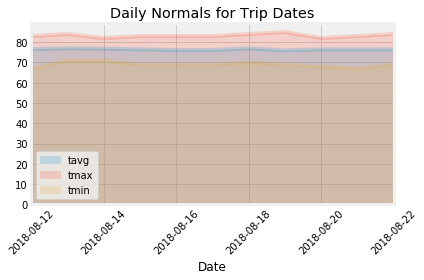

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title='Daily Normals for Trip Dates', rot=45)
plt.tight_layout()
plt.savefig("Images/Daily_Normals.png")
plt.show()